In [ ]:
!pip install sklearn2pmml

In [ ]:
!pip install --upgrade SQLAlchemy

In [125]:
import pandas as pd

import matplotlib.pyplot as plt
import aoa

import teradataml as tdml
from teradataml import *

import getpass

tdml.options.configure.val_install_location = "val"
import warnings
warnings.filterwarnings('ignore')

In [126]:
engine = create_context(
    host="demo-june-2024-03p9jzrz3oc8j7qv.env.clearscape.teradata.com"
    , username="demo_user"
    , password="demo_user")

### Load the data for the demo if it does not exists

In [117]:
df = pd.read_csv('Iris.csv')

In [ ]:
#copy_to_sql(df = df, table_name = 'iris_v1', if_exists='replace')
fastload(df = df, table_name = 'iris', if_exists='replace')

In [14]:
tdf = DataFrame('iris')
tdf.head()

id,sepal_length,sepal_width,petal_length,petal_width,species
3,4.7,3.2,1.3,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
1,5.1,3.5,1.4,0.2,Iris-setosa


### Set up for modelOPS

In [8]:
query = '''CREATE SET TABLE byom_models 
     (
      model_version VARCHAR(255) CHARACTER SET LATIN NOT CASESPECIFIC,
      model_id VARCHAR(255) CHARACTER SET LATIN NOT CASESPECIFIC,
      model_type VARCHAR(255) CHARACTER SET LATIN NOT CASESPECIFIC,
      project_id VARCHAR(255) CHARACTER SET LATIN NOT CASESPECIFIC,
      deployed_at TIMESTAMP(6) DEFAULT CURRENT_TIMESTAMP(6),
      model BLOB(2097088000))
UNIQUE PRIMARY INDEX ( model_version );
'''

try:
    execute_sql(query)
except:
    db_drop_table('byom_models')
    execute_sql(query)

In [9]:
DataFrame('byom_models')

model_version,model_id,model_type,project_id,deployed_at,model


In [11]:
#ddl for PPredictions
query = '''CREATE MULTISET TABLE kmean_predictions 
     (
      job_id VARCHAR(255) CHARACTER SET LATIN NOT CASESPECIFIC,
      CustomerID BIGINT,
      td_clusterid_kmeans INTEGER,
      json_report CLOB(1048544000) CHARACTER SET LATIN)
PRIMARY INDEX ( job_id );;
'''

try:
    execute_sql(query)
except:
    db_drop_table('kmean_predictions')
    execute_sql(query)

In [12]:
DataFrame('kmean_predictions')

job_id,CustomerID,td_clusterid_kmeans,json_report


In [21]:
gry = '''CREATE MULTISET TABLE iris_feature_metadata ,FALLBACK ,
     NO BEFORE JOURNAL,
     NO AFTER JOURNAL,
     CHECKSUM = DEFAULT,
     DEFAULT MERGEBLOCKRATIO,
     MAP = TD_MAP1
     (
      column_name VARCHAR(1024) CHARACTER SET UNICODE NOT CASESPECIFIC,
      column_type VARCHAR(1024) CHARACTER SET UNICODE NOT CASESPECIFIC,
      stats VARCHAR(1024) CHARACTER SET UNICODE NOT CASESPECIFIC,
      update_ts VARCHAR(1024) CHARACTER SET UNICODE NOT CASESPECIFIC)
PRIMARY INDEX(column_name) ;'''

try:
    execute_sql(gry)
except:
    db_drop_table('iris_feature_metadata')
    execute_sql(gry)

In [22]:
DataFrame('iris_feature_metadata')

column_name,column_type,stats,update_ts


### Method that populates statistic table

In [23]:
continuous_features = ['sepal_length','sepal_width','petal_length','petal_width']
categorical_features = []
schema_name="demo_user"
table_name ="iris"
metadata_table = 'iris_feature_metadata'

# Compute statistics for continuous variables
print('Compute statistics for continuous variables : ',continuous_features)
if len(continuous_features)>0 :
        features_df = tdml.DataFrame(tdml.in_schema(schema_name, table_name))
        fs = aoa.compute_continuous_stats(
            features_df         = features_df,
            continuous_features = [c.lower() for c in continuous_features]
        )
        aoa.stats.store.save_feature_stats(
            features_table      = metadata_table,
            feature_type        = "continuous",
            stats               = fs
        )
        
# Compute statistics for categorical variables
print('Compute statistics for categorical variables : ',categorical_features)
if len(categorical_features)>0:
        features_df = tdml.DataFrame(tdml.in_schema(schema_name, table_name))
        fs = aoa.compute_categorical_stats(
            features_df          = features_df,
            categorical_features = [c.lower() for c in categorical_features]
        )
        aoa.stats.store.save_feature_stats(
            features_table = metadata_table,
            feature_type   = "categorical",
            stats          = fs
        )

Compute statistics for continuous variables :  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Compute statistics for categorical variables :  []


In [127]:
DataFrame(metadata_table)

column_name,column_type,stats,update_ts
sepal_length,continuous,"{""edges"": [4.3, 4.66, 5.02, 5.38, 5.74, 6.1, 6.46, 6.82, 7.18, 7.54, 7.9]}",2024-06-24 21:40:46.000000-04:00
petal_length,continuous,"{""edges"": [1.0, 1.59, 2.18, 2.77, 3.36, 3.95, 4.54, 5.13, 5.72, 6.31, 6.9]}",2024-06-24 21:40:46.000000-04:00
sepal_width,continuous,"{""edges"": [2.0, 2.24, 2.48, 2.72, 2.96, 3.2, 3.44, 3.68, 3.92, 4.16, 4.41]}",2024-06-24 21:40:46.000000-04:00
petal_width,continuous,"{""edges"": [0.1, 0.34, 0.58, 0.82, 1.06, 1.3, 1.54, 1.78, 2.02, 2.26, 2.5]}",2024-06-24 21:40:46.000000-04:00


### Train Kmeans in database

In [26]:
KMeans_out = KMeans(id_column="id"
                          ,target_columns=['sepal_length','sepal_width','petal_length','petal_width']
                          ,data=tdf
                         ,num_clusters = 3)

In [27]:
df_model = KMeans_out.result.to_pandas()
df_model

,td_clusterid_kmeans,sepal_length,sepal_width,petal_length,petal_width,td_size_kmeans,td_withinss_kmeans,id,td_modelinfo_kmeans
0,0.0,5.216667,3.640000,1.473333,0.280000,30.0,5.660333,None,None
1,1.0,6.314583,2.895833,4.973958,1.703125,96.0,118.651875,None,None
2,2.0,4.741667,2.954167,1.754167,0.329167,24.0,18.547083,None,None
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Converged : True
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Iterations : 4
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Number of Clusters : 3
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Total_WithinSS : 1.42859291666663E+02
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Between_SS : 5.37965108333333E+02
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,Method for InitialCentroids : Random


In [28]:
x = list(df_model[df_model['sepal_length'].notnull()]["sepal_length"])
y = list(df_model[df_model['petal_length'].notnull()]["petal_length"])
z = list(df_model[df_model['sepal_width'].notnull()]["sepal_width"])
print(x,y,z)

[5.216666666666667, 6.314583333333334, 4.741666666666666] [1.4733333333333332, 4.973958333333333, 1.7541666666666664] [3.6399999999999997, 2.8958333333333335, 2.954166666666667]


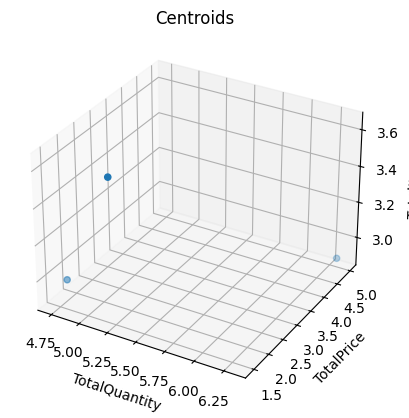

In [29]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z)
ax.set_xlabel('TotalQuantity')
ax.set_ylabel('TotalPrice')
ax.set_zlabel(r'TotalItems')
plt.title('Centroids')

plt.show()

In [30]:
copy_to_sql(df = KMeans_out.result, table_name = 'k_means_model', if_exists='replace')

In [31]:
KMeansPredict_out = KMeansPredict(object=KMeans_out.result,
                                      data=tdf)

In [32]:
KMeansPredict_out.result

id,td_clusterid_kmeans
10,2
5,0
9,2
3,2
11,0
4,2
8,0
12,2
7,2
1,0


In [33]:
tdf1 = tdf.join(other = KMeansPredict_out.result
            , on = ["id=id"], how = "inner", lprefix = "t1")
obj = Antiselect(data=tdf1,
                     exclude=['t1_id'])

In [35]:
df_kmeans_scored = obj.result.to_pandas()
df_kmeans_scored

,id,sepal_length,sepal_width,petal_length,petal_width,species,td_clusterid_kmeans
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,2
2,3,4.7,3.2,1.3,0.2,Iris-setosa,2
3,4,4.6,3.1,1.5,0.2,Iris-setosa,2
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0
...,...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica,1
146,147,6.3,2.5,5.0,1.9,Iris-virginica,1
147,148,6.5,3.0,5.2,2.0,Iris-virginica,1
148,149,6.2,3.4,5.4,2.3,Iris-virginica,1


In [37]:
x = list(df_kmeans_scored[df_kmeans_scored['sepal_length'].notnull()]["sepal_length"])
y = list(df_kmeans_scored[df_kmeans_scored['petal_length'].notnull()]["petal_length"])
z = list(df_kmeans_scored[df_kmeans_scored['sepal_width'].notnull()]["sepal_width"])
col = list(df_kmeans_scored[df_kmeans_scored['td_clusterid_kmeans'].notnull()]["td_clusterid_kmeans"])

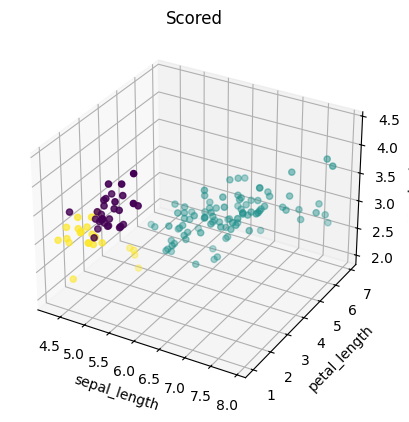

In [38]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c=col)
ax.set_xlabel('sepal_length')
ax.set_ylabel('petal_length')
ax.set_zlabel('sepal_width')
plt.title('Scored')

plt.show()

In [49]:
list(df_kmeans_scored)

['id',
 'sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'td_clusterid_kmeans']

In [71]:
df_cnt = df_kmeans_scored.groupby(['species','td_clusterid_kmeans']).size()
df_cnt

species          td_clusterid_kmeans
Iris-setosa      0                      30
                 2                      20
Iris-versicolor  1                      46
                 2                       4
Iris-virginica   1                      50
dtype: int64

In [80]:
#df_cnt["td_clusterid_kmeans"]#          td_clusterid_kmeanstpe
df_c = df_cnt.to_frame().reset_index()

In [89]:
df_c["cnt"] = df_c[0]
df_c = df_c.drop(columns=[0])

In [110]:
df_c

,species,td_clusterid_kmeans,cnt
0,Iris-setosa,0,30
1,Iris-setosa,2,20
2,Iris-versicolor,1,46
3,Iris-versicolor,2,4
4,Iris-virginica,1,50


<Axes: xlabel='td_clusterid_kmeans', ylabel='cnt'>

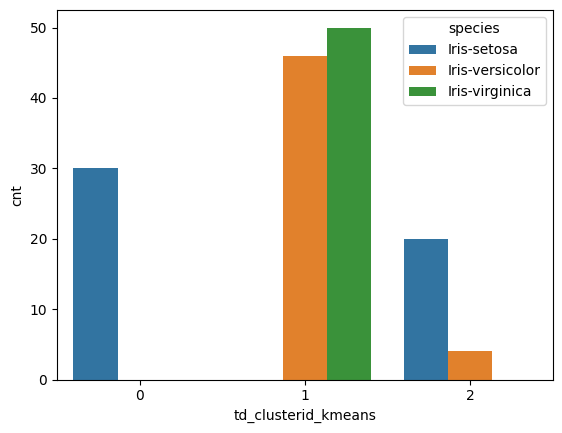

In [124]:

import seaborn as sns
#ax = df_c.plot.bar(x = 'td_clusterid_kmeans', y ='cnt', rot=0, hue)

sns.barplot(x=df_c.td_clusterid_kmeans, y=df_c.cnt, hue = df_c.species)